# Tugas Akhir Remedial

## JCDSOL-21
##### Armand Marcell Richir

### Problem and Goals

Mobil99 adalah startup dealer mobil bekas yang beroperasi di Arab Saudi. Permasalahan utama yang ingin diselesaikan adalah bagaimana menentukan listing mobil yang profitable untuk diakuisisi, rekondisi, lalu dijual.

Proses Bisnis Mobil99 
- Pembelian: Mobil99 mengakuisisi mobil bekas dari masyarakat.
- Rekondisi: Setiap mobil yang dibeli melalui proses pengecekan menyeluruh, perbaikan, servis, dan pemeliharaan untuk memastikan kualitasnya.
- Penjualan: Mobil yang telah direkondisi dijual kepada konsumen.

Permasalahan utama yang ingin diselesaikan ada di tahap akusisi mobil bekas. Dikarenakan keterbatasan SDM, melihat cukup banyak variabel yang menentukan harga mobil bekas, diperlukan sebuah algoritma yang dapat merekomendasikan listing mobil secara instan dengan mempertimbangkan harga pasar mobil tersebut dan juga biaya rekondisi mobil tersebut. 

Dengan dataset yang berisi mobil - mobil bekas di Arab Saudi (diambil dari Syarah.com), diharapkan dapat membuat algoritma machine learning yang dapat langsung memberi rekomendasi dari listing mobil (dalam Syarah.com) yang "worth-it" untuk diakuisisi sehingga Mobil99 menjadi profitable.

### Data Source

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data_saudi_used_cars.csv')
display(df.head())
print()
print("Missing values per column:")
display(df.isnull().sum())


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0



Missing values per column:


Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

Bisa Terlihat dari data diatas, dataset memiliki 11 kolom

### Data Handling - Duplication

In [2]:
duplicate_rows = df[df.duplicated()]

print(duplicate_rows)

df = df.drop_duplicates()

        Type  Region     Make  Gear_Type Origin   Options  Year  Engine_Size  \
953      Rio  Riyadh      Kia  Automatic  Saudi  Standard  2016          1.4   
4646  Sonata  Jeddah  Hyundai  Automatic  Saudi  Standard  2020          2.4   
4933  Tucson  Dammam  Hyundai  Automatic  Saudi  Standard  2016          2.0   
5267   Camry  Riyadh   Toyota  Automatic  Saudi      Full  2013          2.5   

      Mileage  Negotiable  Price  
953    270000       False  25000  
4646      100       False  72910  
4933   155000       False  45000  
5267   185000        True      0  


### Data Handling - Misc

Karena dataset juga meng-include listing dari mobil yang fully negotiable (dimana Price nya ditetapkan menjadi 0), dibagi dataset menjadi 2 yakni yang negotiable dan non-negotiable. Untuk analisis prediksi harga hanya akan melihat dataset yang (Non-Negotiable). Dikarenakan mobil dengan listing yang Negotiable memiliki price yang otomatis (0). Sehingga dinilai akan terlalu berpengaruh terhadap prediction power model nya nanti. Dibawah ini Dataset dihandle apakah ada yang tidak konsisten dari kolom Negotiable nya tersebut.

In [3]:
negotiable_with_price = df[(df["Negotiable"] == True) & (df["Price"] > 0)]
print(f"Number of negotiable cars with actual prices: {len(negotiable_with_price)}")
print(negotiable_with_price.head())

nonnegotiable_without_price = df[(df["Negotiable"] == False) & (df["Price"] == 0)]
print()
print(f"Number of non-negotiable cars without actual prices: {len(nonnegotiable_without_price)}")
print(nonnegotiable_without_price.head())

Number of negotiable cars with actual prices: 0
Empty DataFrame
Columns: [Type, Region, Make, Gear_Type, Origin, Options, Year, Engine_Size, Mileage, Negotiable, Price]
Index: []

Number of non-negotiable cars without actual prices: 1
           Type  Region    Make  Gear_Type Origin    Options  Year  \
3168  Furniture  Riyadh  Toyota  Automatic  Other  Semi Full  2012   

      Engine_Size  Mileage  Negotiable  Price  
3168          2.7   225000       False      0  


In [4]:
df_negotiable = df[df["Negotiable"] == True]
df_nonnegotiable = df[(df["Negotiable"] == False) & (df["Price"] > 0)]

print("Negotiable listings:", len(df_negotiable))
print("Non-negotiable listings:", len(df_nonnegotiable))

Negotiable listings: 1795
Non-negotiable listings: 3824


### Data Handling - Outlier

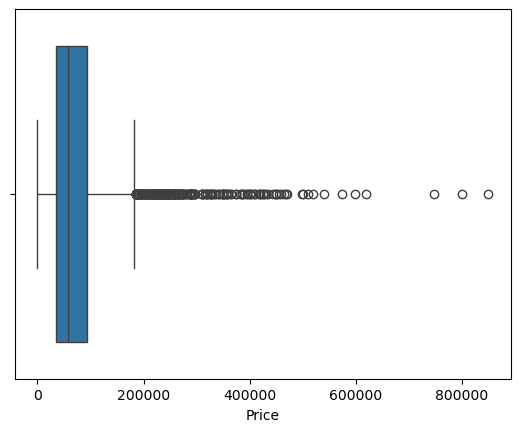

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df_nonnegotiable['Price'])
plt.show()

Bisa terlihat untuk harga - harga dari dataset Non-Negotiable, ada beberapa outlier yang tinggi. Dikarenakan listing outlier sangat berpengaruh untuk prediction power model yang ingin dibuat, dibuat data-handling dengan cara mengatur batas tinggi harga yang dimasuki dalam model yang akan digunakan. Batas tinggi secara statistik yang digunakan adalah Q3 + 3*IQR terlihat dibawah

In [6]:
Q1 = df_nonnegotiable['Price'].quantile(0.25)
Q3 = df_nonnegotiable['Price'].quantile(0.75)
IQR = Q3 - Q1

upper_limit_extreme = Q3 + 3 * IQR

print(f"Upper Limit is:{upper_limit_extreme}")
high_price_listings = df_nonnegotiable[df_nonnegotiable['Price'] > upper_limit_extreme]
high_price_listings

Upper Limit is:272000.0


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
233,GLE,Riyadh,Mercedes,Automatic,Other,Full,2020,6.9,24000,False,330000
246,CLA,Riyadh,Mercedes,Automatic,Other,Full,2020,2.0,15000,False,410000
251,Vanquish,Dammam,Aston Martin,Automatic,Saudi,Full,2013,6.0,32000,False,400000
362,The 7,Riyadh,BMW,Automatic,Gulf Arabic,Full,2019,2.0,6000,False,335000
526,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.6,18000,False,285000
...,...,...,...,...,...,...,...,...,...,...,...
5149,LX,Riyadh,Lexus,Automatic,Gulf Arabic,Full,2020,5.7,105,False,425000
5246,Yukon,Aseer,GMC,Automatic,Saudi,Full,2021,5.3,3700,False,310000
5423,GTB 599 Fiorano,Dammam,Ferrari,Automatic,Saudi,Full,2008,6.0,59000,False,280000
5487,IS,Jeddah,Lexus,Automatic,Saudi,Full,2018,3.5,54000,False,275000


Agar model yang dikembangkan lebih akurat, listing harga mobil dibawah 10000 Riyal juga dihapus. Dikarenakan listing mobil dengan harga dibawah 10000 Riyal kemungkinan besar dihasilkan dari human error (mis-input).

In [7]:
df_nonnegotiable = df_nonnegotiable[df_nonnegotiable['Price'] <= upper_limit_extreme]

df_nonnegotiable = df_nonnegotiable[df_nonnegotiable['Price'] >= 10000]

Non-negotiable listings: 3625


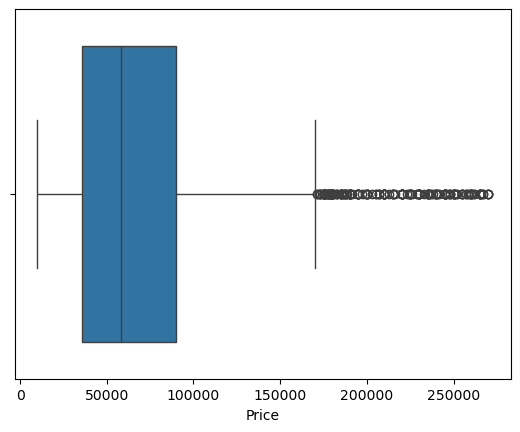

In [8]:
print("Non-negotiable listings:", len(df_nonnegotiable))
sns.boxplot(x=df_nonnegotiable['Price'])
plt.show()

Terlihat dari Boxplot diatas, sudah tidak ada outlier di bagian Price

### Exploratory Data Analysis

Di bagian ini akan memulai plotting agar bisa lebih mengerti dataset, dan juga memvisualisasikan jika ada dataset yang perlu diproses.

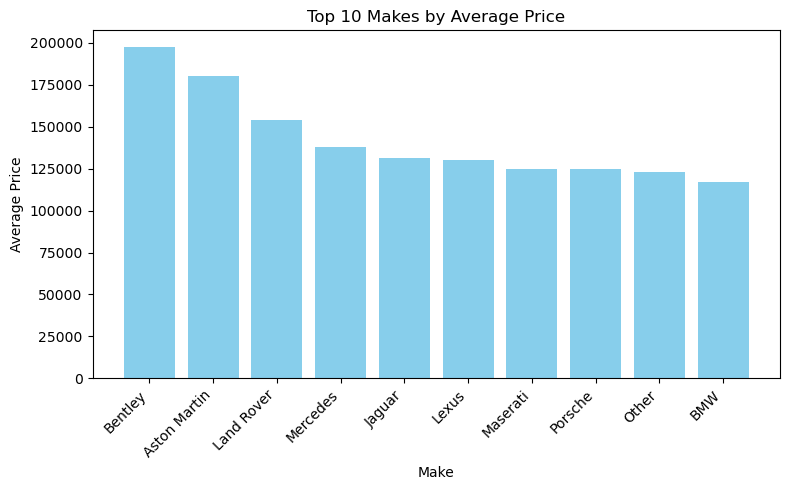

In [9]:
import matplotlib.pyplot as plt

avg_price_make = df_nonnegotiable.groupby('Make')['Price'].mean().reset_index()
avg_price_make = avg_price_make.sort_values('Price', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.bar(avg_price_make['Make'], avg_price_make['Price'], color='skyblue')
plt.title("Top 10 Makes by Average Price")
plt.xlabel("Make")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Terlihat dari histogram diatas, menampilkan merk mobil dengan rata - rata harga tertinggi (top 10). Bentley merupakan merk mobil dengan rata - rata harga tertinggi (jika dibandingkan merk lain)

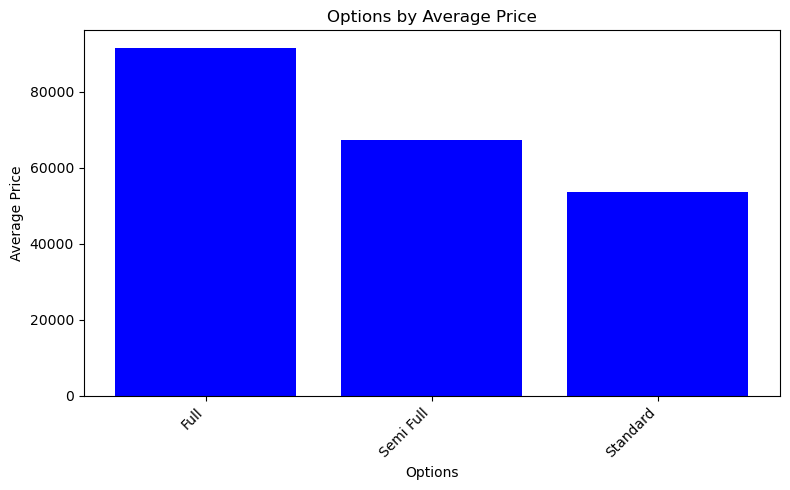

In [10]:
avg_price_options = df_nonnegotiable.groupby('Options')['Price'].mean().reset_index()


plt.figure(figsize=(8, 5))
plt.bar(avg_price_options['Options'], avg_price_options['Price'], color='blue')
plt.title("Options by Average Price")
plt.xlabel("Options")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Diatas merupakan Histogram dari "Options", untuk hasilnya sesuai ekspektasi karena memang seharusnya options Full lebih mahal dari Semi Full; dan Semi Full lebih mahal dari Standard.

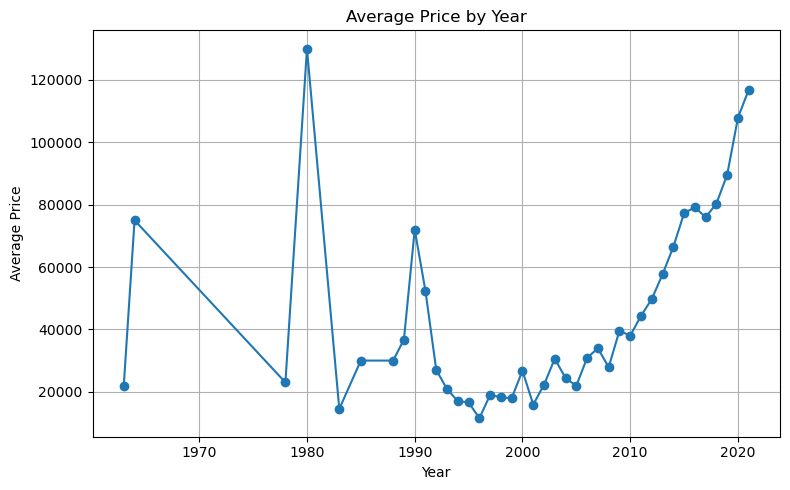

In [11]:
avg_price_year = df_nonnegotiable.groupby('Year')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(avg_price_year['Year'], avg_price_year['Price'], marker='o')
plt.title("Average Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Untuk line Chart diatas, bisa terlihat tepat di tahun 1980, ada "spike" dari rata - rata harga. Ini kemungkinan terjadi karena mayoritas mobil bekas di tahun 1980 kebetulan masuk ke arah "classic car".

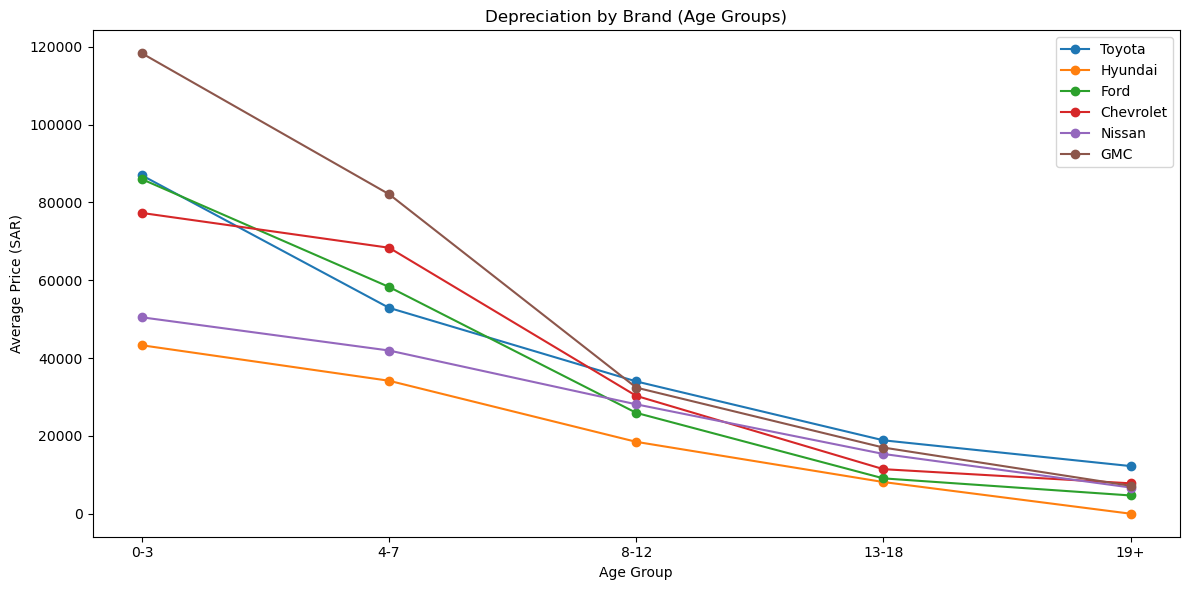

In [12]:
from datetime import datetime

current_year = 2022
df["Age"] = current_year - df["Year"]

# Age bins
bins = [0, 3, 7, 12, 18, 100]
labels = ["0-3", "4-7", "8-12", "13-18", "19+"]
df["Age_Group"] = pd.cut(df["Age"], bins=bins, labels=labels, right=True)

# Avg price per brand per age group
brand_age_group = df.groupby(["Make", "Age_Group"], observed = False)["Price"].mean().reset_index()


top_brands = df["Make"].value_counts().head(6).index
subset = brand_age_group[brand_age_group["Make"].isin(top_brands)]

plt.figure(figsize=(12,6))

for brand in top_brands:
    temp = subset[subset["Make"] == brand]
    plt.plot(temp["Age_Group"], temp["Price"], marker="o", label=brand)

plt.title("Depreciation by Brand (Age Groups)")
plt.xlabel("Age Group")
plt.ylabel("Average Price (SAR)")
plt.legend()
plt.tight_layout()
plt.show()


Chart diatas menunjukkan top 6 brand yang paling banyak (Toyota, Hyundai, Ford, Chevrolet, Nissan dan GMC). Juga menunjukkan harga vs umur mobil, bisa dilihat setelah lebih dari 7 tahun; harga pasar mobil langsung turun cukup tinggi. Sehingga direkomendasikan untuk Mobil99 agar menghindari mengakuisisi mobil lebih tua dari 8 tahun.

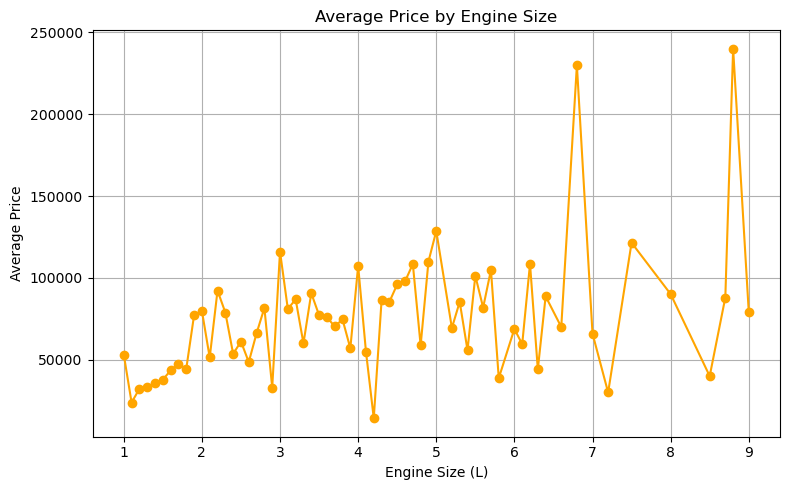

In [13]:
avg_price_engine = df_nonnegotiable.groupby('Engine_Size')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(avg_price_engine['Engine_Size'], avg_price_engine['Price'], marker='o', color='orange')
plt.title("Average Price by Engine Size")
plt.xlabel("Engine Size (L)")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Ini menunjukkan rata - rata harga dari berbagai Engine Size.

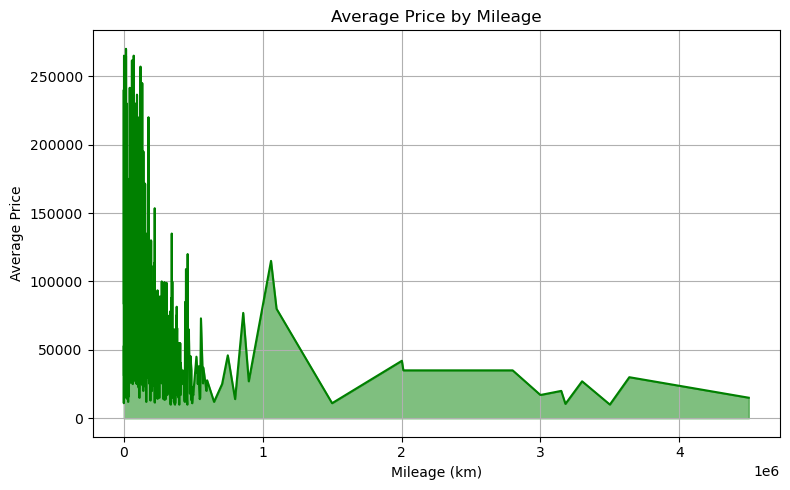

In [14]:
df_nonnegotiable = df_nonnegotiable[df_nonnegotiable["Mileage"] < 10000000]

avg_price_mileage = df_nonnegotiable.groupby('Mileage')['Price'].mean().reset_index()
avg_price_mileage = avg_price_mileage.sort_values('Mileage')


plt.figure(figsize=(8, 5))
plt.fill_between(avg_price_mileage["Mileage"], avg_price_mileage["Price"], color="green", alpha=0.5)
plt.plot(avg_price_mileage['Mileage'], avg_price_mileage['Price'], color='green')
plt.title("Average Price by Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

Terlihat diatas adalah area chart dari rata - rata harga mobil dengan Mileage nya. Dari chart diatas bisa dilihat kalau semakin besar mileage nya, semakin kecil rata rata harga mobil bekas (dari 0km hingga ~50000km); namun setelah lebih dari ~200000 km. Nilai harga mobil sudah mulai stagnan.

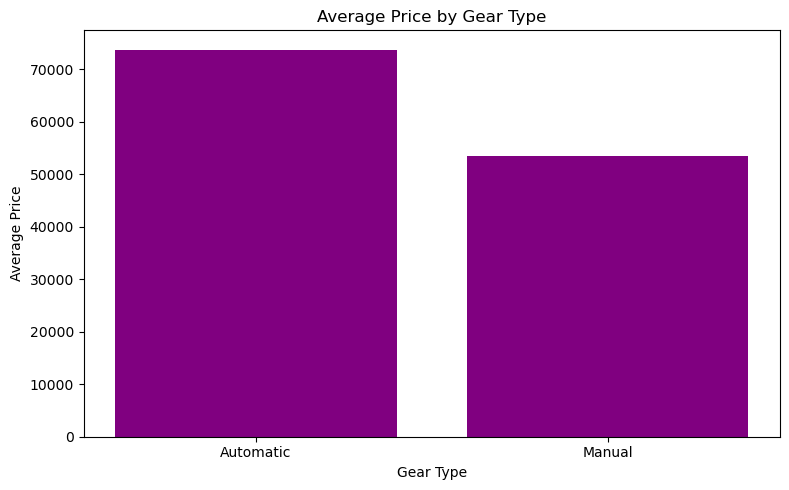

In [15]:
avg_price_gear = df_nonnegotiable.groupby('Gear_Type')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(avg_price_gear['Gear_Type'], avg_price_gear['Price'], color='purple')
plt.title("Average Price by Gear Type")
plt.xlabel("Gear Type")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

Bar chart diatas menunjukkan rata - rata harga dari mobil automatic dan mobil manual. 

### Machine Learning

#### Feature Selection

Untuk seleksi fitur yang digunakan, diperlakukan ANOVA test untuk fitur numerikal; dan Mutual Information Test untuk fitur kategorikal.

In [16]:
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder

df = df_nonnegotiable.copy()

categorical_cols = ['Type','Make','Gear_Type','Options', 'Origin', 'Region']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

X = df[['Type','Make', 'Year', 'Engine_Size', 'Mileage',
        'Gear_Type','Options', 'Origin', 'Region']]
y = df['Price']

# Numeric features → ANOVA regression
numeric_cols = ['Year', 'Engine_Size', 'Mileage']
F_values, p_values = f_regression(X[numeric_cols], y)

anova_result = pd.DataFrame({'Feature': numeric_cols,'F_value': F_values,'p_value': p_values})

categorical_feature_cols = ['Type','Make','Gear_Type','Options','Origin','Region']
mi_scores = mutual_info_regression(X[categorical_feature_cols], y)

mi_result = pd.DataFrame({'Feature': categorical_feature_cols,'Mutual_Info_Score': mi_scores}).sort_values(by='Mutual_Info_Score', ascending=False)

print("=== ANOVA Hypothesis Test (Numeric Features) ===")
print(anova_result)

print("\n=== Mutual Information Test (Categorical Features) ===")
print(mi_result)

=== ANOVA Hypothesis Test (Numeric Features) ===
       Feature     F_value        p_value
0         Year  527.529117  4.239805e-109
1  Engine_Size  385.834119   1.034168e-81
2      Mileage  157.377075   2.277052e-35

=== Mutual Information Test (Categorical Features) ===
     Feature  Mutual_Info_Score
0       Type           0.358643
1       Make           0.221068
3    Options           0.103521
4     Origin           0.052807
5     Region           0.052072
2  Gear_Type           0.029236


- Untuk fitur numerikal (Year, Engine_Size, Mileage) semua digunakan karena p-value nya dibawah 0.05
- Untuk fitur kategorikal hanya top 3 saja yang diambil (Type, Make, Options) karena fitur kategorikal lainnya dinilai akan terlalu kecil kontribusinya.

In [17]:
X = df_nonnegotiable[['Type','Make', 'Year', 'Engine_Size', 'Mileage','Options']]
y = df_nonnegotiable['Price']

#### Modeling

Dilakukan berbagai model Machine Learning, yaitu:
- Random Forest Regressor
- Linear Regression
- Decision Tree Regression
- Gradient Boosting Regression
- Support Vector Regression
- CatBoost

#### Random Forest Regressor

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

categorical_cols = ['Type','Make','Options']
numerical_cols = ['Year', 'Engine_Size', 'Mileage']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols), ('num', 'passthrough', numerical_cols)])

model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', RandomForestRegressor(random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"R² score: {score:.2f}")

R² score: 0.82


In [19]:
from sklearn.metrics import mean_absolute_error

y_predrf = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predrf)
print(f"Mean Absolute Error: {mae:,.0f}")

Mean Absolute Error: 12,024


#### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lin_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

lin_model.fit(X_train, y_train)

y_predlin = lin_model.predict(X_test)

print("Linear Regression")
print(f"R² score: {r2_score(y_test, y_predlin):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_predlin):,.0f}")

Linear Regression
R² score: 0.38
Mean Absolute Error: 27,593


#### Decision Tree Regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor

dt_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', DecisionTreeRegressor(random_state=42))])

dt_model.fit(X_train, y_train)

y_preddt = dt_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score
print("Decision Tree Regressor")
print(f"R² score: {r2_score(y_test, y_preddt):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_preddt):,.0f}")

Decision Tree Regressor
R² score: 0.75
Mean Absolute Error: 14,898


#### Gradient Boosting Regressor

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', GradientBoostingRegressor(random_state=42))])

gb_model.fit(X_train, y_train)

y_predgb = gb_model.predict(X_test)

print("Gradient Boosting Regressor")
print(f"R² score: {r2_score(y_test, y_predgb):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_predgb):,.0f}")

Gradient Boosting Regressor
R² score: 0.83
Mean Absolute Error: 13,574


#### Support Vector Regressor

In [23]:
from sklearn.svm import SVR

svr_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', SVR(kernel='rbf'))])

svr_model.fit(X_train, y_train)

y_predsvr = svr_model.predict(X_test)

print("Support Vector Regressor (SVR)")
print(f"R² score: {r2_score(y_test, y_predsvr):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_predsvr):,.0f}")

Support Vector Regressor (SVR)
R² score: -0.06
Mean Absolute Error: 35,283


#### CatBoost

In [24]:
from catboost import CatBoostRegressor
from sklearn.compose import TransformedTargetRegressor

cat_model = CatBoostRegressor(random_state=0, cat_features=categorical_cols, verbose=False)

cat_model.fit(X_train,y_train,cat_features=categorical_cols)
 
y_pred_cat = cat_model.predict(X_test)

print("Catboost")
print(f"R² score: {r2_score(y_test, y_pred_cat):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_cat):,.0f}")

Catboost
R² score: 0.87
Mean Absolute Error: 10,794


### Evaluation Matrix

Dilakukan Evaluation Matrix dari model - model yang sudah dilakukan diatas.

In [25]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error

results = []

results.append({"Model": "Random Forest","R²": r2_score(y_test, y_predrf),"MAE": mean_absolute_error(y_test, y_predrf),"RMSE": root_mean_squared_error(y_test, y_predrf),
                "MAPE": mean_absolute_percentage_error(y_test, y_predrf),"Median Abs. Er.": median_absolute_error(y_test, y_predrf)})
results.append({"Model": "Decision Tree","R²": r2_score(y_test, y_preddt),"MAE": mean_absolute_error(y_test, y_preddt),"RMSE": root_mean_squared_error(y_test, y_preddt),
                "MAPE": mean_absolute_percentage_error(y_test, y_preddt),"Median Abs. Er.": median_absolute_error(y_test, y_preddt)})
results.append({"Model": "Linear Regression","R²": r2_score(y_test, y_predlin),"MAE": mean_absolute_error(y_test, y_predlin),"RMSE": root_mean_squared_error(y_test, y_predlin),
                "MAPE": mean_absolute_percentage_error(y_test, y_predlin),"Median Abs. Er.": median_absolute_error(y_test, y_predlin)})
results.append({"Model": "Gradient Boosting","R²": r2_score(y_test, y_predgb),"MAE": mean_absolute_error(y_test, y_predgb),"RMSE": root_mean_squared_error(y_test, y_predgb),
                "MAPE": mean_absolute_percentage_error(y_test, y_predgb),"Median Abs. Er.": median_absolute_error(y_test, y_predgb)})
results.append({"Model": "SVR","R²": r2_score(y_test, y_predsvr),"MAE": mean_absolute_error(y_test, y_predsvr),"RMSE": root_mean_squared_error(y_test, y_predsvr),
                "MAPE": mean_absolute_percentage_error(y_test, y_predsvr),"Median Abs. Er.": median_absolute_error(y_test, y_predsvr)})
results.append({"Model": "Catboost","R²": r2_score(y_test, y_pred_cat),"MAE": mean_absolute_error(y_test, y_pred_cat),"RMSE": root_mean_squared_error(y_test, y_pred_cat),
                "MAPE": mean_absolute_percentage_error(y_test, y_pred_cat),"Median Abs. Er.": median_absolute_error(y_test, y_pred_cat)})

eval_matrix = pd.DataFrame(results)
display(eval_matrix)

,Model,R²,MAE,RMSE,MAPE,Median Abs. Er.
0,Random Forest,0.822991,12023.960240,21159.564785,0.195461,6275.000000
1,Decision Tree,0.749740,14897.757241,25159.666523,0.248357,8000.000000
2,Linear Regression,0.379859,27592.899466,39605.399919,0.540113,19152.312122
3,Gradient Boosting,0.830185,13573.838470,20725.111312,0.255077,8981.989938
4,SVR,-0.055974,35283.074785,51681.590784,0.676196,23722.081636
5,Catboost,0.870023,10793.528082,18131.849044,0.178777,6177.297031


In [26]:
y_predrf_train = model.predict(X_train)
y_predlin_train = lin_model.predict(X_train)
y_preddt_train = dt_model.predict(X_train)
y_predgb_train = gb_model.predict(X_train)
y_predsvr_train = svr_model.predict(X_train)
y_pred_cat_train = cat_model.predict(X_train)

results_train = []

results_train.append({"Model": "Random Forest","R²": r2_score(y_train, y_predrf_train),"MAE": mean_absolute_error(y_train, y_predrf_train),
                      "RMSE": root_mean_squared_error(y_train, y_predrf_train),"MAPE": mean_absolute_percentage_error(y_train, y_predrf_train),
                      "Median Abs. Er.": median_absolute_error(y_train, y_predrf_train)})

results_train.append({"Model": "Decision Tree","R²": r2_score(y_train, y_preddt_train),"MAE": mean_absolute_error(y_train, y_preddt_train),
                      "RMSE": root_mean_squared_error(y_train, y_preddt_train),"MAPE": mean_absolute_percentage_error(y_train, y_preddt_train),
                      "Median Abs. Er.": median_absolute_error(y_train, y_preddt_train)})

results_train.append({"Model": "Linear Regression","R²": r2_score(y_train, y_predlin_train),"MAE": mean_absolute_error(y_train, y_predlin_train),
                      "RMSE": root_mean_squared_error(y_train, y_predlin_train),"MAPE": mean_absolute_percentage_error(y_train, y_predlin_train),
                      "Median Abs. Er.": median_absolute_error(y_train, y_predlin_train)})

results_train.append({"Model": "Gradient Boosting","R²": r2_score(y_train, y_predgb_train),"MAE": mean_absolute_error(y_train, y_predgb_train),
                      "RMSE": root_mean_squared_error(y_train, y_predgb_train),"MAPE": mean_absolute_percentage_error(y_train, y_predgb_train),
                      "Median Abs. Er.": median_absolute_error(y_train, y_predgb_train)})

results_train.append({"Model": "SVR","R²": r2_score(y_train, y_predsvr_train),"MAE": mean_absolute_error(y_train, y_predsvr_train),
                      "RMSE": root_mean_squared_error(y_train, y_predsvr_train),"MAPE": mean_absolute_percentage_error(y_train, y_predsvr_train),
                      "Median Abs. Er.": median_absolute_error(y_train, y_predsvr_train)})

results_train.append({"Model": "Catboost","R²": r2_score(y_train, y_pred_cat_train),"MAE": mean_absolute_error(y_train, y_pred_cat_train),
                      "RMSE": root_mean_squared_error(y_train, y_pred_cat_train),"MAPE": mean_absolute_percentage_error(y_train, y_pred_cat_train),
                      "Median Abs. Er.": median_absolute_error(y_train, y_pred_cat_train)})

eval_matrix_train = pd.DataFrame(results_train)
display(eval_matrix_train)

,Model,R²,MAE,RMSE,MAPE,Median Abs. Er.
0,Random Forest,0.979202,4304.587088,7262.056984,0.069580,2467.500000
1,Decision Tree,0.999955,21.551724,336.244472,0.000304,0.000000
2,Linear Regression,0.365637,27896.976149,40106.874448,0.552437,19945.907682
3,Gradient Boosting,0.870834,13138.207236,18097.745002,0.238761,9662.684729
4,SVR,-0.075810,35770.307645,52229.742022,0.643720,24781.997686
5,Catboost,0.929801,8705.504155,13341.823613,0.141035,5581.655073


Dari Hasil Evaluation Matrix dari kedua train dan test data diatas, bisa dilihat kalau CatBoost dan Gradient Boosting memiliki performa yang paling bagus jika dilihat dari Evaluation Matrix nya karena memiliki perbandingan metric yang mirip antara hasil train dan hasil test nya (sedikit/mild overfitting).

Untuk Random Forest dan Decision Tree dinilai Overfitting karena hasil Train nya sangat tinggi jika dibandingkan dengan hasil Test nya.

### Cross-Evaluation

Cross Evaluation digunakan sebagai pembandingan yang lebih reliable, untuk memastikan bahwa hasil evaluation matrix nya dapat di-replicable. Metode yang digunakan adalah K-fold (K = 5), dimana model di train sebanyak 4 kali dan di evaluasi di iterasi yang ke-5.

In [27]:
scorer_list = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "medae": "neg_median_absolute_error"
}

In [28]:
from sklearn.model_selection import cross_validate, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_cv = []

rf_cv = cross_validate(model, X, y, cv=kf, scoring=scorer_list) #Random Forest
results_cv.append({
    "Model": "Random Forest",
    "CV R² (mean)": rf_cv["test_r2"].mean(),
    "CV R² (std)":  rf_cv["test_r2"].std(),
    "CV MAE (mean)": -rf_cv["test_mae"].mean(),
    "CV RMSE (mean)": -rf_cv["test_rmse"].mean(),
    "CV MedAE (mean)": -rf_cv["test_medae"].mean()
})

dt_cv = cross_validate(dt_model, X, y, cv=kf, scoring=scorer_list) #Decision Tree
results_cv.append({
    "Model": "Decision Tree",
    "CV R² (mean)": dt_cv["test_r2"].mean(),
    "CV R² (std)":  dt_cv["test_r2"].std(),
    "CV MAE (mean)": -dt_cv["test_mae"].mean(),
    "CV RMSE (mean)": -dt_cv["test_rmse"].mean(),
    "CV MedAE (mean)": -dt_cv["test_medae"].mean()
})

lin_cv = cross_validate(lin_model, X, y, cv=kf, scoring=scorer_list) #Linear Regression
results_cv.append({
    "Model": "Linear Regression",
    "CV R² (mean)": lin_cv["test_r2"].mean(),
    "CV R² (std)":  lin_cv["test_r2"].std(),
    "CV MAE (mean)": -lin_cv["test_mae"].mean(),
    "CV RMSE (mean)": -lin_cv["test_rmse"].mean(),
    "CV MedAE (mean)": -lin_cv["test_medae"].mean()
})

gb_cv = cross_validate(gb_model, X, y, cv=kf, scoring=scorer_list) #Gradient Boosting
results_cv.append({
    "Model": "Gradient Boosting",
    "CV R² (mean)": gb_cv["test_r2"].mean(),
    "CV R² (std)":  gb_cv["test_r2"].std(),
    "CV MAE (mean)": -gb_cv["test_mae"].mean(),
    "CV RMSE (mean)": -gb_cv["test_rmse"].mean(),
    "CV MedAE (mean)": -gb_cv["test_medae"].mean()
})

svr_cv = cross_validate(svr_model, X, y, cv=kf, scoring=scorer_list) #Support Vector Regressor
results_cv.append({
    "Model": "Support Vector Regressor",
    "CV R² (mean)": svr_cv["test_r2"].mean(),
    "CV R² (std)":  svr_cv["test_r2"].std(),
    "CV MAE (mean)": -svr_cv["test_mae"].mean(),
    "CV RMSE (mean)": -svr_cv["test_rmse"].mean(),
    "CV MedAE (mean)": -svr_cv["test_medae"].mean()
})

cat_cv = cross_validate(cat_model, X, y, cv=kf, scoring=scorer_list) #CatBoost
results_cv.append({
    "Model": "CatBoost",
    "CV R² (mean)": cat_cv["test_r2"].mean(),
    "CV R² (std)":  cat_cv["test_r2"].std(),
    "CV MAE (mean)": -cat_cv["test_mae"].mean(),
    "CV RMSE (mean)": -cat_cv["test_rmse"].mean(),
    "CV MedAE (mean)": -cat_cv["test_medae"].mean()
})

cv_eval_matrix = pd.DataFrame(results_cv)
display(cv_eval_matrix)

,Model,CV R² (mean),CV R² (std),CV MAE (mean),CV RMSE (mean),CV MedAE (mean)
0,Random Forest,0.845769,0.019827,11880.640135,19714.711059,6775.800000
1,Decision Tree,0.742140,0.009556,15535.275034,25549.783189,8600.000000
2,Linear Regression,0.365320,0.019388,27838.635507,40091.178398,19796.697385
3,Gradient Boosting,0.831537,0.007655,14040.234221,20647.157313,9632.189652
4,Support Vector Regressor,-0.075068,0.017343,35676.549198,52176.692219,24389.695722
5,CatBoost,0.875238,0.012700,11074.379378,17742.261648,6609.878072


Setelah dilakukan Cross Evaluation dengan model - model diatas, bisa diliihat kalau metode CatBoost memiliki nilai R-Squared (mean) lebih tinggi dari Gradient Boosting. Juga memiliki nilai - nilai error paling rendah dibandingkan semua model (MAE, RMSE, MedAE)

Sehingga bisa dipastikan kalau model CatBoost lebih bisa memprediksi dengan lebih akurat jika dibandingkan dengan model lain yang digunakan disini.

#### Transform Target

Transform Target mengubah data train price (y_train) menjadi fungsi logaritma (log). Ini dilakukan agar menurunkan error akibat skewness data dan juga skala data.

TransformTarget dilakukan ke model CatBoost dan model Gradient Boosting (top 2 model dari hasil evaluation matrix dan cross validation diatas).

In [29]:
from sklearn.compose import TransformedTargetRegressor

logtransform_model = TransformedTargetRegressor(regressor=cat_model,
                                                     func=np.log, # To Log Transform
                                                     inverse_func=np.exp # To automatically convert to normal scale
                                                     )

logtransform_model.fit(X_train, y_train)

y_train_pred = logtransform_model.predict(X_train)
y_test_pred = logtransform_model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)

MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

RMSE_train = root_mean_squared_error(y_train, y_train_pred)
RMSE_test = root_mean_squared_error(y_test, y_test_pred)


print("CatBoost - Transformed")
print(f"Train MAE: {MAE_train:}")
print(f"Test MAE: {MAE_test:}")

print("-" * 50)

print(f"Train MAPE: {MAPE_train:%}")
print(f"Test MAPE: {MAPE_test:%}")

print("-" * 50)
print(f"Train RMSE: {RMSE_train:}")
print(f"Test RMSE: {RMSE_test:}")

CatBoost - Transformed
Train MAE: 8832.013241259943
Test MAE: 10728.059061382712
--------------------------------------------------
Train MAPE: 12.649291%
Test MAPE: 16.258765%
--------------------------------------------------
Train RMSE: 14728.349833823437
Test RMSE: 18851.379501007923


In [30]:
from sklearn.compose import TransformedTargetRegressor

logtransform_model_GB = TransformedTargetRegressor(regressor=gb_model,
                                                     func=np.log, # To Log Transform
                                                     inverse_func=np.exp # To automatically convert to normal scale
                                                     )

logtransform_model_GB.fit(X_train, y_train)

y_train_pred = logtransform_model_GB.predict(X_train)
y_test_pred = logtransform_model_GB.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)

MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

RMSE_train = root_mean_squared_error(y_train, y_train_pred)
RMSE_test = root_mean_squared_error(y_test, y_test_pred)

print("Gradient Boosting - Transformed")
print(f"Train MAE: {MAE_train:}")
print(f"Test MAE: {MAE_test:}")

print("-" * 50)

print(f"Train MAPE: {MAPE_train:%}")
print(f"Test MAPE: {MAPE_test:%}")

print("-" * 50)
print(f"Train RMSE: {RMSE_train:}")
print(f"Test RMSE: {RMSE_test:}")

Gradient Boosting - Transformed
Train MAE: 13059.285642603969
Test MAE: 13815.524827566114
--------------------------------------------------
Train MAPE: 19.629236%
Test MAPE: 21.180105%
--------------------------------------------------
Train RMSE: 20429.334522057077
Test RMSE: 23129.908227667507


### HyperParameter Tuning

Dilakukan Hyperparameter tuning terhadap metode CatBoost - Transformed (karena setelah dibandingkan dengan evaluation matrix dan cross evaluation, model CatBoost - Transformed terbukti paling baik).

In [31]:
params_space = {   
    # CatBoostRegressor parameters (accessed through regressor__)

    # Loss Functions
    'regressor__loss_function': ["MAE", "MAPE", "RMSE"],

    # Basic parameters
    'regressor__n_estimators': np.arange(100, 800, 50), # number of trees
    'regressor__learning_rate': np.logspace(-2.5, -0.5, 30),  # 0.003 to ~0.316
    
    # Regularization parameters (KEY FOR OVERFITTING)
    'regressor__l2_leaf_reg': np.logspace(0, 2, 30),  # 1 to 100
    'regressor__bagging_temperature': np.linspace(0, 2.5, 15),
        
    # Tree structure constraints
    'regressor__min_data_in_leaf': np.arange(5, 50, 5),
    'regressor__depth': np.arange(3, 9),
        
}
scorer_list = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "medae": "neg_median_absolute_error"
}

In [32]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=logtransform_model,
    param_distributions=params_space,
    n_iter=50,                
    scoring=scorer_list,
    refit="medae",
    cv=5,                     
    n_jobs=-1,                
    random_state=0
)

random_search

random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                        inverse_func=<ufunc 'exp'>,
                                                        regressor=<catboost.core.CatBoostRegressor object at 0x00000135C69A4440>),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__bagging_temperature': array([0.        , 0.17857143, 0.35714286, 0.53571429, 0.71428571,
       0.89285714, 1.07142857, 1.25      , 1.42857143, 1.607142...
                                        'regressor__loss_function': ['MAE',
                                                                     'MAPE',
                                                                     'RMSE'],
                                        'regressor__min_data_in_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'regressor__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750])},
                   random_state=0, refit='medae',
                   scoring={'mae': 'neg_mean_absolute_error',
                            'medae': 'neg_median_absolute_error', 'r2': 'r2',
                            'rmse': 'neg_root_mean_squared_error'})

In [33]:
random_search.best_params_ 

best_ttr_cat = random_search.best_estimator_

y_pred_tuned = best_ttr_cat.predict(X_test)

results.append({
    "Model": "TTR CatBoost (Tuned)",
    "R²": r2_score(y_test, y_pred_tuned),
    "MAE": mean_absolute_error(y_test, y_pred_tuned),
    "RMSE": root_mean_squared_error(y_test, y_pred_tuned),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred_tuned),
    "Median Abs. Er.": median_absolute_error(y_test, y_pred_tuned)
})

eval_matrix = pd.DataFrame(results)
display(eval_matrix)

,Model,R²,MAE,RMSE,MAPE,Median Abs. Er.
0,Random Forest,0.822991,12023.960240,21159.564785,0.195461,6275.000000
1,Decision Tree,0.749740,14897.757241,25159.666523,0.248357,8000.000000
2,Linear Regression,0.379859,27592.899466,39605.399919,0.540113,19152.312122
3,Gradient Boosting,0.830185,13573.838470,20725.111312,0.255077,8981.989938
4,SVR,-0.055974,35283.074785,51681.590784,0.676196,23722.081636
5,Catboost,0.870023,10793.528082,18131.849044,0.178777,6177.297031
6,TTR CatBoost (Tuned),0.865340,10557.918094,18455.599500,0.163245,5658.725979


Setelah dilakukan hyperparameter tuning, bisa dilihat skor r-squared nya mirip (antara original CatBoost dan CatBoost-Tuned), namun skor Mean Absolute Error, Median Absolute Error, Mean Absolute Percentage Error nya juga turun sehingga hasil setiap prediksi nya lebih akurat. Sehingga dinilai lebih baik menggunakan CatBoost - Transformed - Tuned. 

### Residual Analysis

Residual adalah selisih dari data aktual dengan hasil prediksi, analisis residual dilakukan untuk mem-verifikasi hasil prediksi dari model terbaik yang digunakan (CatBoost-Transformed-Tuned).

In [34]:
from sklearn.metrics import mean_squared_error
residuals = y_test - y_pred_tuned

mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
MAPE = mean_absolute_percentage_error(y_test, y_pred_tuned)



print("Residual Analysis for Tuned TTR-CatBoost")
print("----------------------------------------")
print(f"MAPE  :{MAPE:.2%}")
print(f"MAE   :{mae:,.2f}")
print(f"RMSE  :{rmse:,.2f}")

Residual Analysis for Tuned TTR-CatBoost
----------------------------------------
MAPE  :16.32%
MAE   :10,557.92
RMSE  :18,455.60


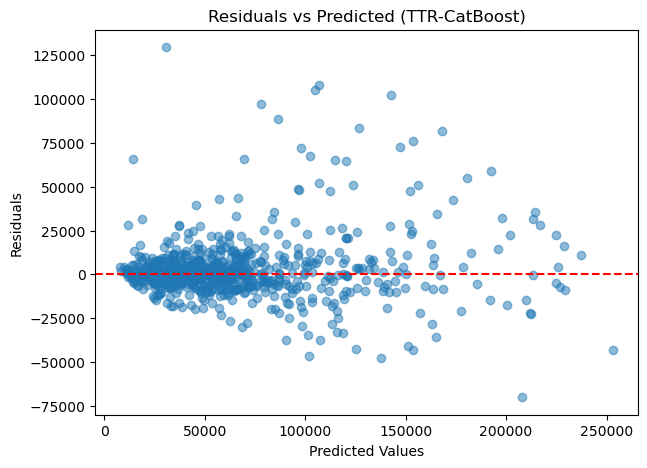

In [35]:
plt.figure(figsize=(7,5))
plt.scatter(y_pred_tuned, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (TTR-CatBoost)")
plt.show()

Hasil plotting residual vs prediksi data bisa dilihat di grafik diatas. Terlihat bahwa untuk model ini, hasil prediksi nya "centered" ke nilai 0, sehingga dinilai baik dalam memprediksi harga pasar. Semakin besar nilai prediksi nya juga semakin besar residual nya ("spread" nya semakin besar), hasil tersebut wajar dalam model prediksi harga pasar yang dilakukan. Hasil plotting nya pun juga terlihat "random" (tidak ada pola yang terbuat) sehingga model dinilai berhasil proses "fitting" nya.

### SHAP and Model Explanation

Setelah menganalisa berbagai jenis model machine learning, ditentukan model CatBoost-Transformed-Tuned menjadi model yang paling baik dalam memprediksi harga pasar. Model CatBoost (Categorial Boosting), merupakan model machine learning yang menggunakan teknik Boosting; dimana di dalam teknik Boosting diurutkan model - model yang lemah sehingga model selanjutnya dapat fokus kepada kesalahan model sebelumnnya. Didalam CatBoost sendiri sudah bisa mengatasi fitur kategorikal secara langsung (tidak perlu encoding). Sehingga CatBoost memiliki keunggulan dalam dataset mobil bekas seperti projek ini (Make, Type, Options merupakan data kategorikal).

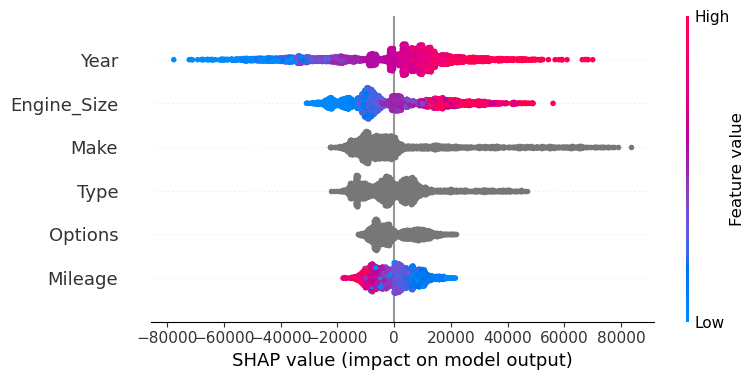

In [36]:
import shap

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

SHapley Additive exPlanation atau (SHAP), memvisualisasikan bagaimana fitur2 yang digunakan mempengaruhi output dari model (dalam kasus ini bagaimana fitur memprediksi harga). Bisa dilihat dari Summary SHAP diatas, kalau Year dan Engine_Size memiliki pengaruh yang besar terhadap hasil prediksi model. Sedangkan, Mileage dinilai memiliki SHAP Value yang rendah dibandingkan fitur2 lain yang digunakan.

Setelah melakukan berbagai model machine learning untuk memprediksi harga mobil yang akan dijual, metode CatBoost (Tuned and Transformed) menjadi algoritma terbaik untuk digunakan.

In [37]:
best_model = best_ttr_cat
X = df_nonnegotiable[['Type','Make','Year','Engine_Size','Mileage','Options']]
y = df_nonnegotiable['Price']
best_model.fit(X,y)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=<catboost.core.CatBoostRegressor object at 0x00000135C6A0FC80>)

## Actionable Insight Example

#### Assumptions

Dalam melakukan permasalahan utama di projek ini, digunakan 3 asumsi:
- Tidak ada pajak platform (Ketika membeli atau menjual listing, tidak ada biaya tambahan)
- Biaya rekondisi/restorasi mengikuti formula: [restoration_cost = 2500 + 400 * age + 150 * (Mileage / 10000)]
- Setelah akuisisi dan rekondisi, mobil dijual tepat pada predicted price.

Setelah mendapatkan best machine learning model, langung dipraktekan didalam dataset listing syarah.com nya.

Dengan mengikuti formula seperti berikut:
### (Listing Price + Estimated Restoration Cost) + 10000 < Predicted Market Value --> reccomended = TRUE
Dimana Estimated Restoration Cost masih dalam bentuk sederhana yakni:
### restoration_cost = 2500 + 400 * age + 150 * (Mileage / 10000) 

NOTE: Untuk formula ini bisa dikembangkan lagi dengan data aktual lapangan.

In [38]:
X = df_nonnegotiable[['Type','Make','Year','Engine_Size','Mileage','Options']]
current_year = 2022
df_nonnegotiable['Age'] = current_year - df_nonnegotiable['Year']


df_nonnegotiable['Predicted_Price'] = best_model.predict(X)

df_nonnegotiable['Restoration_Cost'] = (
    2500 + 
    400 * df_nonnegotiable['Age'] + 
    150 * (df_nonnegotiable['Mileage'] / 10000))


df_nonnegotiable['Total_Investment'] = (
    df_nonnegotiable['Price'] + df_nonnegotiable['Restoration_Cost']
)


df_nonnegotiable['Expected_Profit'] = (
    df_nonnegotiable['Predicted_Price'] - df_nonnegotiable['Total_Investment']
)


df_nonnegotiable['Recommended'] = df_nonnegotiable['Expected_Profit'] > 10000


recommended_table = df_nonnegotiable[
    df_nonnegotiable['Recommended'] == True
].sort_values(by='Expected_Profit', ascending=False)[[
    'Type','Make','Year','Engine_Size','Mileage','Gear_Type','Options',
    'Price','Age','Predicted_Price','Restoration_Cost',
    'Total_Investment','Expected_Profit']]

display(recommended_table.head())
recommended_table.shape

,Type,Make,Year,Engine_Size,Mileage,Gear_Type,Options,Price,Age,Predicted_Price,Restoration_Cost,Total_Investment,Expected_Profit
1889,Q,INFINITI,2019,3.5,5000,Automatic,Full,90500,3,171383.883199,3775.00,94275.00,77108.883199
4558,Range Rover,Land Rover,2017,5.0,150000,Automatic,Full,115000,5,183132.175292,6750.00,121750.00,61382.175292
3832,Range Rover,Land Rover,2018,5.0,26000,Automatic,Full,170000,4,229378.578864,4490.00,174490.00,54888.578864
4269,Range Rover,Land Rover,2015,2.0,113000,Automatic,Full,100000,7,160866.271251,6995.00,106995.00,53871.271251
3127,LX,Lexus,2014,5.7,342,Automatic,Full,150000,8,205125.394106,5705.13,155705.13,49420.264106


(222, 13)

Tabel diatas adalah top 5 dari listing rekomendasi (diurutkan dari Expected Profit terbesar). Total dari recommended listing ada 222 listing.

In [39]:
total_investment_sum = recommended_table['Total_Investment'].sum()
expected_profit_sum = recommended_table['Expected_Profit'].sum()
total_revenue_sum = recommended_table['Predicted_Price'].sum()
print("Total Investment (Sum):", total_investment_sum)
print("Expected Total Revenue (Sum):", total_revenue_sum)
print("Expected Profit (Sum):", expected_profit_sum)

total_roi = expected_profit_sum / total_investment_sum
print("Total ROI:", total_roi)
print("Total ROI (%):", total_roi * 100)

Total Investment (Sum): 25367221.48
Expected Total Revenue (Sum): 30003204.289399564
Expected Profit (Sum): 4635982.809399566
Total ROI: 0.1827548520855807
Total ROI (%): 18.27548520855807


Keterangan diatas adalah jumlah (Sum) dari seluruh recommended table. 
- Kalau semua isi dari recommended listing dibeli, maka total pengeluaran adalah: 25,367,221.48 SAR.
- Dengan Expected Revenue sebesar : 30,003,204.29 SAR.
- Juga Expected Profit (Keuntungan) sebesar : 4,635,982.8 SAR
- Return of Investment nya sebesar : 18.27%

### Model Limitation

- Dataset yang digunakan dalam pengembangan model adalah dataset dengan kriteria "Negotiable = False", jadi data yang termasuk bisa di-negosiasi (Negotiable = True) tidak masuk dalam dataset yang dikembangkan di model ini
- Dataset juga tidak ada informasi mengenai sejarah mobil dalam listing nya (tidak ada informasi mengenai sejarah kecelakaan, sejarah kepunyaan, sejarah servis, dll.) sehingga informasi untuk membuat estimasi harga restorasi terbatas.
- Model hanya fokus terhadap harga jual pasar, tidak dipengaruhi oleh hal seperti:
  - Seberapa cepat listing akan laku/terjual
  - Demand market mobil bekas
  - Trend market mobil bekas
- Model dapat memprediksi harga berdasarkan korelasi dari fitur - fitur, bukan kausalitas.

## Kesimpulan

- Model Machine Learning yang digunakan untuk menyelesaikan masalah Mobil99 dalam menentukan listing mobil yang "worth-it" diakuisisi, restorasi, lalu dijual adalah Catboost-Transformed-Tuned.
- Jumlah listing yang menurut model "worth-it" untuk diproses Mobil99 ada 222.
- Expected Profit ketika mengikuti asumsi - asumsi yang dinyatakan adalah 4,635,982.8 SAR; dengan RoI sebesar 18.27%

### Saran

- Rumus dari restoration cost masih flat, bisa dikembangkan lebih lanjut dengan rumus empirik berdasarkan projek - projek restorasi yang berjalan.
- Melakukan Filtering lebih lanjut untuk listing yang masih "Too good to be true".

display(df_nonnegotiable.head())
df_nonnegotiable.shape

df_nonnegotiable.to_csv('NonNegotiableDatas(incl_Reccomended).csv', index=False)